In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt

os.chdir("/content/drive/My Drive/GitHub Repositories/Weakly-Supervised Classification and Localization of Common Thorax Diseases")

!ls


 datasets   DenseNet-121   EffecientNetB0  'saved models'


In [5]:
import EffecientNetB0.Architecture.keras as efn
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras import *

diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
              'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
IMG_SIZE = 224
channels = 1
dataDir = './datasets/images_batch'
images = os.listdir(dataDir)

def LungsDiseasesModel():
  lungs_model = efn.EfficientNetB0(weights=None, include_top=1, input_shape = (IMG_SIZE, IMG_SIZE, channels) )
  lungs_model.load_weights("./saved models/EffecientNetB0/EffecientnetB0-bestweights.hdf5")
  return lungs_model

lungs_model = LungsDiseasesModel()
lungs_model.summary()




Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

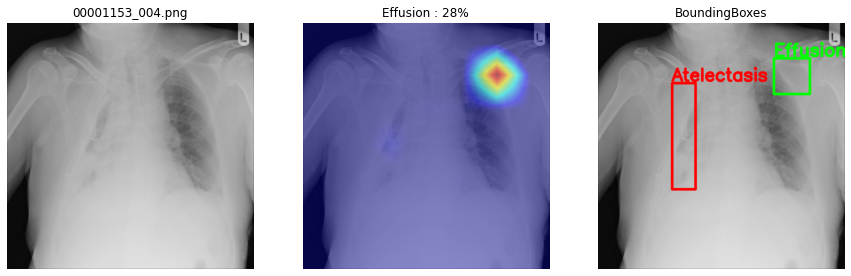

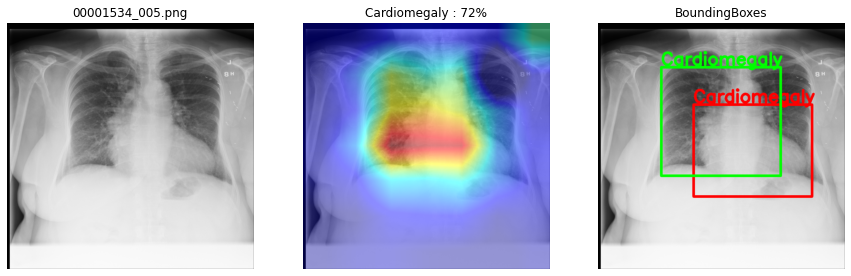

In [0]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2
import pandas as pd

layer_name = 'top_activation'
generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
csvFile = pd.read_csv('./datasets/bbox_batch.csv')

def BBoxes_from_GroundTruths(imgName, img2bbox):
  groundTruths = csvFile.loc[(csvFile['Image Index'] == imgName)]
  for label in groundTruths:
    disease = groundTruths['Finding Label']
    x, y, w, h = groundTruths['Bbox [x'], 	groundTruths['y'], 	groundTruths['w'], 	groundTruths['h]']
    BoundingBoxImage = cv2.rectangle(img2bbox, (x, y), (x+w, y+h), (255, 0, 0), 10)
    cv2.putText(BoundingBoxImage, '{}'.format(disease.values[0]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (255, 0, 0), 10)
  return BoundingBoxImage

def GradCam(input_model, image, cls, layer_name, W, H):
  # GradCAM method for visualizing input saliency
  y_c = input_model.output[0, cls]
  conv_output = input_model.get_layer(layer_name).output
  grads = K.gradients(y_c, conv_output)[0]

  gradient_function = K.function([input_model.input], [conv_output, grads])

  output, grads_val = gradient_function([image])
  output, grads_val = output[0, :], grads_val[0, :, :, :]

  weights = np.mean(grads_val, axis=(0, 1))
  filtermap = np.dot(output, weights)

  filtermap = cv2.resize(filtermap, (W, H), cv2.INTER_LINEAR)
  filtermap = np.maximum(filtermap, 0)
  filtermap = filtermap / filtermap.max()

  smoothfiltermap = cv2.normalize(filtermap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  smoothfiltermap = cv2.applyColorMap(smoothfiltermap, cv2.COLORMAP_JET)

  heatmap = cv2.applyColorMap(np.uint8(255 * filtermap), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  return smoothfiltermap, heatmap
  
def GenerateBoundingBoxes(smoothfiltermap):
  scale_list = [1, 1, 1, 1] 
  grey_img = cv2.cvtColor(smoothfiltermap, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(grey_img, 127, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh, 1, 2)

  for item in range(len(contours)):
    cnt = contours[item]
    if len(cnt) > 20:
        x, y, w, h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
        poly_coords = [cnt] # polygon coordinates are based on contours
        
        x = int(x * scale_list[0]) # rescaling the boundary box based on user input
        y = int(y * scale_list[1])
        w = int(w * scale_list[2])
        h = int(h * scale_list[3])
        
        return x, y, w, h, poly_coords, grey_img, contours
    
    else: print("contour error (too small)")
    
def Plot_Results(prediction, diseases, imgName, img_to_predict):
  prediction_scores = []
  for i in range(len(prediction[0])):
    prediction_scores.append(prediction[0][i]*100)
  
  Highest_Prob = prediction_scores.index(max(prediction_scores))
  
  if diseases[Highest_Prob] == 'No Finding' and prediction_scores[Highest_Prob] > 85:
    print('Xray: {} | Normal'.format(imgName))
  else:
    index = diseases.index('No Finding')
    del diseases[index], prediction_scores[index]
    result = ['{}:{:.0f}'.format(disease, score) for disease, score in sorted(zip(diseases, prediction_scores), key=lambda x: x[1], reverse=1)]
    # print('Xray: {} | Diseases: {}'.format(imgName, result[:3]))
    # print('Xray : {}'.format(imgName))
  
    sorted_Diseases = np.argsort(-prediction, axis=1)
    labels = result[:1]
    top_3_Diseases = sorted_Diseases[:, :1]
    
    oriImg = np.asarray(load_img(os.path.join(dataDir, imgName)))
    img2bbox = np.asarray(load_img(os.path.join(dataDir, imgName)))
    W, H = img2bbox.shape[0], img2bbox.shape[1]
    BoundingBoxImage = BBoxes_from_GroundTruths(imgName, img2bbox)
    
    
    plt.figure(figsize = (15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(oriImg)
    plt.title(imgName)
    plt.axis('off')
    for i in range(len(top_3_Diseases[0])):
      cls = top_3_Diseases[0][i]
      smoothfiltermap, heatmap = GradCam(lungs_model, img_to_predict, cls, layer_name, W, H)
      
      x, y, w, h, poly_coords, grey_img, contours= GenerateBoundingBoxes(smoothfiltermap)
      BoundingBoxImage= cv2.rectangle(img2bbox, (x, y), (x + w, y + h), (0, 255, 0), 10)
      cv2.putText(BoundingBoxImage, '{}'.format(labels[i].split(':')[0]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 2.4, (0, 255, 0), 10)
      
      superimposed_img = cv2.addWeighted(oriImg, 0.6, heatmap, 0.5, 0)

      plt.subplot(1, 3, i+2)
      plt.imshow(superimposed_img)
      plt.title('{} : {}%'.format(labels[i].split(':')[0], labels[i].split(':')[1]))
      plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(BoundingBoxImage)
    plt.title('BoundingBoxes')
    plt.axis('off')
    plt.show()



 
    
def IdentifyLungsDiseasePatterns(lungs_model, imgName):
  img_path = os.path.join(dataDir, imgName)
  diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
              'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

  img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
  img = np.expand_dims(img_to_array(img), axis=0)

  preprocessing = generator.flow(img) 
  img_to_predict = next(preprocessing)

  prediction = lungs_model.predict(img_to_predict)

  Plot_Results(prediction, diseases, imgName, img_to_predict)

count = 0
for imgName in sorted(images):
  count+=1
  IdentifyLungsDiseasePatterns(lungs_model, imgName)
  if count==5:
    break

  
    

  
  




